## 
    Time period	: 1940 - 2023
    
    location:   s(cell,bs="mrf",k=25, xt=list(nb=nb)) 
    
    scale	    s(cell,bs="mrf",k=25, xt=list(nb=nb))
    shape       s(cell,bs="mrf",k=25, xt=list(nb=nb))



In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from copy import copy
import geopandas as gpd
from shapely.geometry import Point

In [2]:
import rpy2
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv

extRemes = importr("extRemes")
evgam = importr("evgam")
raster = importr("raster")
tidyverse = importr("tidyverse")
sf = importr("sf")
spdep = importr("spdep")
terra = importr("terra")
mgcv = importr("mgcv")

%load_ext rpy2.ipython

In [4]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [5]:
import warnings
warnings.filterwarnings('ignore')

# READ AFI, DJF Temperature and topography FILES

In [6]:
yearb=1941
yeare=2023

dirin ='/Users/ghervieux/AFI'

ds = xr.open_dataset(f'{dirin}/Colorado_ij_extremes_gev_1941_2023.nc')
rl100 = ds['rl100'] 
loc = ds['location'] 
scale = ds['scale'] 
shape = ds['shape'] 

units = 'degree-days (°C)'

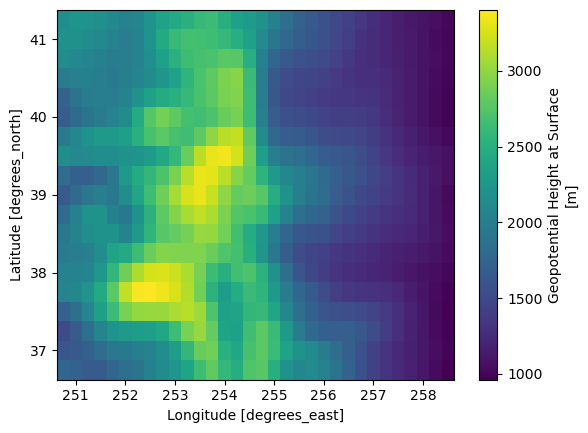

In [7]:
lon_min = 250.6
lon_max = 258.5
lat_min = 36.7
lat_max = 41.3
dshgt = xr.open_dataset('/Users/ghervieux/AFI/hgt.sfc.era5.1.nc')
dshgt = dshgt.sortby('lat')
dshgt = dshgt.isel(time=0, drop=True)
dshgt = dshgt.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
elevation = dshgt['hgt']
elevation.plot()

In [8]:
ds = ds.merge({'elevation':elevation})
ds

<xarray.Dataset> Size: 22kB
Dimensions:    (lat: 19, lon: 32)
Coordinates:
  * lat        (lat) float64 152B 36.75 37.0 37.25 37.5 ... 40.75 41.0 41.25
  * lon        (lon) float64 256B 250.8 251.0 251.2 251.5 ... 258.0 258.2 258.5
Data variables:
    rl100      (lat, lon) float64 5kB ...
    location   (lat, lon) float64 5kB ...
    scale      (lat, lon) float64 5kB ...
    shape      (lat, lon) float64 5kB ...
    elevation  (lat, lon) float32 2kB ...

In [9]:
df = ds.to_dataframe()
df = df.reset_index()

In [12]:
dfg = df[['lat','lon']]
dfg

,lat,lon
0,36.75,250.75
1,36.75,251.00
2,36.75,251.25
3,36.75,251.50
4,36.75,251.75
...,...,...
603,41.25,257.50
604,41.25,257.75
605,41.25,258.00
606,41.25,258.25


In [13]:
# Extract values for boxes
df = ds.to_dataframe()
df = df.reset_index()

dfg = df[['lat','lon']]
dfg['cell'] = np.arange(0,len(dfg))
dfg.index = np.arange(0,len(dfg))
df = pd.merge(df, dfg, on=['lat', 'lon'], how='left')
dfg = dfg.rename(columns={'lon':'x','lat':'y'})

# Convert xarray to pandas DataFrame to R data.frame
# You can now work with 'r_df' in R
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)
  r_dfg = ro.conversion.get_conversion().py2rpy(dfg)
globalenv['r_df'] = r_df
globalenv['r_dfg'] = r_dfg

In [14]:
%R g_raster <- rast(r_dfg) 
%R crs(g_raster) <- "EPSG:4326" 
%R g_raster <-as(g_raster, "Raster")

<rpy2.robjects.methods.RS4 object at 0x16e856ed0> [25]
R classes: ('RasterLayer',)

# Build neighbors list

In [23]:
%%R -w 800 --type=cairo
df_graster <- as.data.frame(g_raster, xy = TRUE)
CellWithData <- which(!is.na(df_graster$cell))
GetNbrs <- lapply(CellWithData, function(i) { raster::adjacent(g_raster, cells=i, directions=4, pairs = FALSE, target = CellWithData) })
#print(raster::adjacent(my_raster,cells=1627,directions=4, pairs=FALSE))
# count number of neighbors for each cell with data:
NbrsLengths <- sapply(GetNbrs, function(i) length(i))
# which indexes of cells with no neighbors with data
NoNbrs <- which(NbrsLengths==0)  # positions 1   2   4  26  41  57 492 have no neighbours
CellsNoNbrs <- CellWithData[NoNbrs]  # 29  68  368  484  528  570 1628
# create list with neighbours info but only for cells that have neighbours
if (any(NoNbrs) == FALSE) {
  NbrsList <- GetNbrs
  CellWithDataAndNbrs <- CellWithData #df_raster[CellWithData,'cell']
  r_df2 <- r_df
} else {
  NbrsList <- GetNbrs[-NoNbrs]
  CellWithDataAndNbrs <- CellWithData[-NoNbrs] #df_raster[CellWithData[-NoNbrs],'cell']
  keeps <- sapply(r_df$cell, function(x) !(x %in% CellsNoNbrs))
  r_df2 <- r_df[keeps, ]
  dim(r_df2)
  r_df2 <- r_df2[complete.cases(r_df2), ]
  length(CellWithDataAndNbrs)
}

# function to take the cells of neighbours and return their index in
# the CellsWithData50 vector; as required for construction of nb; see ?mrf
#=====================
# Input: a single list
GetNbrsIndex <- function(NbrsList){
  n <- length(NbrsList)
  NbrsIndex <- sapply(1:length(NbrsList),
                      function(i) which(CellWithDataAndNbrs==NbrsList[[i]]))
  NbrsIndex
}
#==================================================
# now lapply this to the whole list to create nb (named list)
# of neighborhood info required for mrf smooth in evgam.

FullNbrsList <- lapply(NbrsList, function(i) GetNbrsIndex(i))
nb <- FullNbrsList
names(nb) <- as.factor(df_graster[CellWithDataAndNbrs,'cell'])

r_df2$cell <- as.factor(r_df2$cell)
# in order to use mrf smooth; need to add a column to dataframe
# called nb (factor variable) of all 1's
r_df2$nb <- as.factor(rep(1, nrow(r_df2)))

In [16]:
%R head(r_df)

,lat,lon,rl100,location,scale,shape,elevation,cell
0,36.75,250.75,773.409504,92.672330,76.116855,0.262868,1760.699707,0
1,36.75,251.00,806.405383,99.043821,82.616686,0.246962,1718.259766,1
2,36.75,251.25,953.516747,80.642738,71.650425,0.371694,1657.553223,2
3,36.75,251.50,784.233450,122.230093,97.806915,0.158334,1666.501709,3
4,36.75,251.75,778.508378,163.131434,118.339705,0.052251,1768.392334,4
5,36.75,252.00,820.111721,220.959022,146.036609,-0.050737,1834.851929,5


In [17]:
itest = 'test0_gam_cr10_mrf50'

In [26]:
%R tail(r_df2)

,lat,lon,rl100,location,scale,shape,elevation,cell,nb
602,41.25,257.25,708.949936,186.985120,108.205453,0.020482,1216.346436,602,1
603,41.25,257.50,729.479601,204.033934,116.344356,-0.008023,1163.778198,603,1
604,41.25,257.75,748.384014,226.117738,125.520290,-0.044397,1123.436646,604,1
605,41.25,258.00,761.073346,244.148855,131.992306,-0.071953,1087.949951,605,1
606,41.25,258.25,766.896373,254.062283,135.590596,-0.088088,1051.618164,606,1
607,41.25,258.50,771.519284,261.891446,137.679168,-0.098179,1010.190063,607,1


In [61]:

%R mod <- gam(rl100 ~ te(elevation,cell,bs=c('cr','mrf'),k=c(10,50),xt = list(nb = nb)),, data=r_df2, method="REML")
%R rl1009 <- predict(mod, type = 'response')
%R -o rl1009

In [38]:
%R -o r_df2

In [62]:
rl1009 = pd.DataFrame(rl1009,columns=['rl100'])
rl1009['lat']  = r_df2['lat'].values
rl1009['lon']  = r_df2['lon'].values
dsrl1009 = rl1009.set_index(['lat','lon']).to_xarray()
rl1009 = dsrl1009['rl100']

In [43]:
ds8 = xr.open_dataset(f'{dirin}/Colorado_tensor_cr10_mrf50_loc_sc_sh_1941_2023.nc')
rl1008 = ds8['rl100'].isel(time=0) 
loc8 = ds8['location'].isel(time=0) 
scale8 = ds8['scale'].isel(time=0) 
shape8 = ds8['shape'].isel(time=0) 

In [44]:
rl1000 = ds['rl100']
loc0 = ds['location']
scale0 = ds['scale']
shape0 = ds['shape'] 

Text(0.5, 0.98, 'Return Level 100year, year=1941')

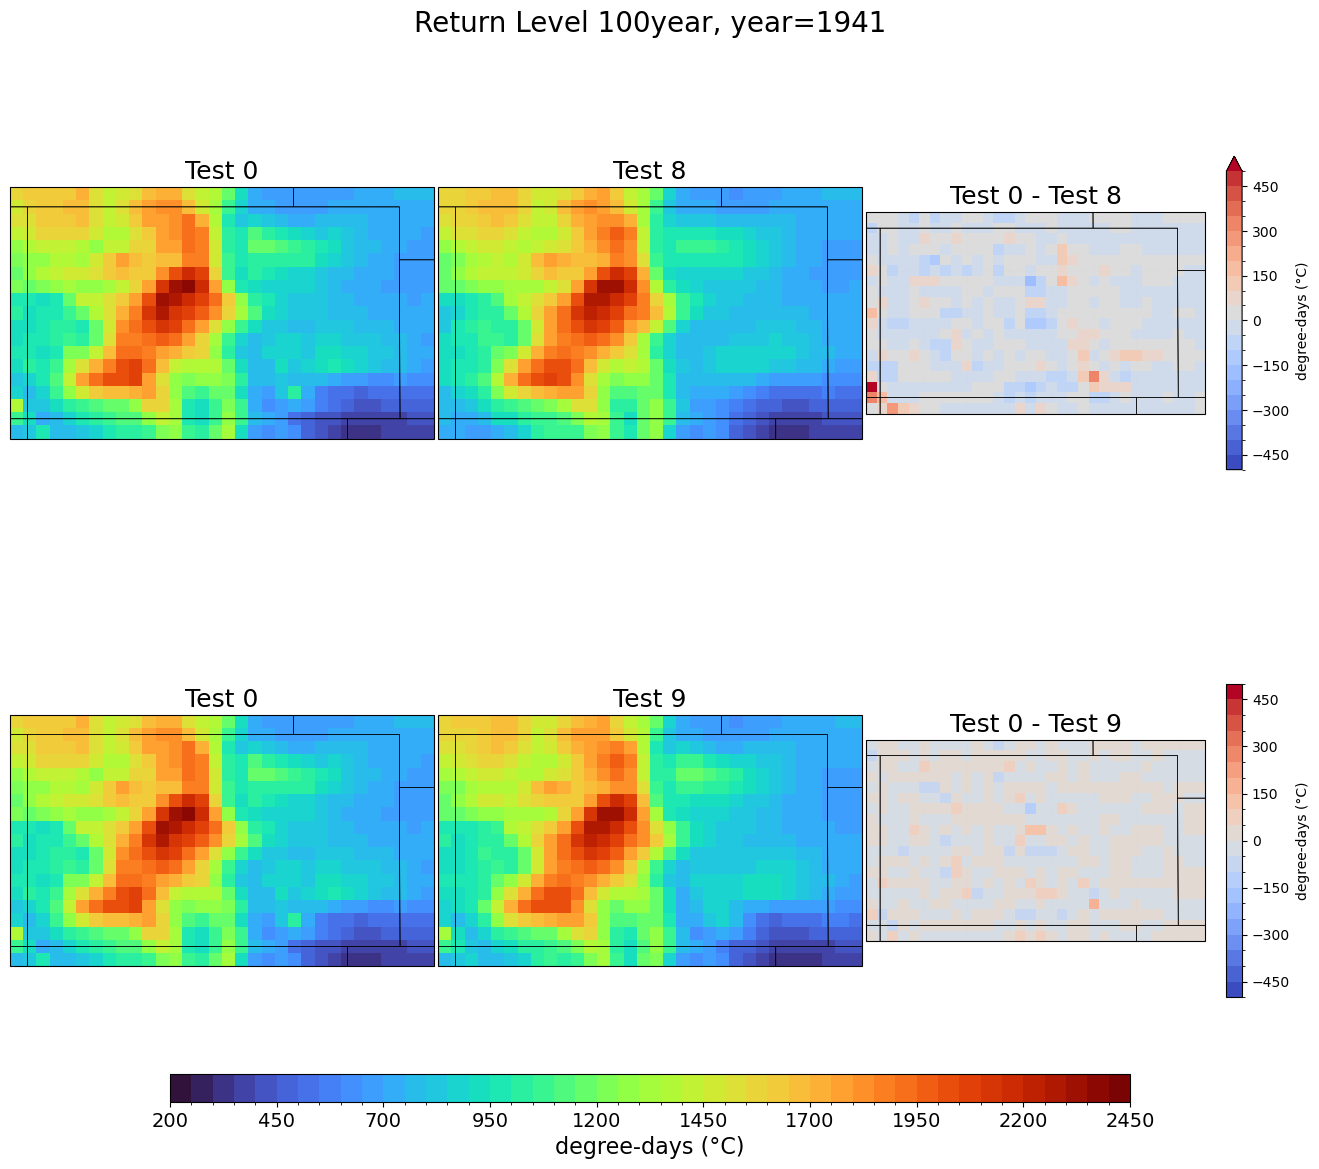

In [63]:
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(16,14),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.2,left=0.1, right=0.9,top=0.95,hspace=0.01,wspace=0.01)
ax = ax.flatten()
for ix in range(0,6,3):
  cc = rl1000.plot.pcolormesh(ax=ax[ix],cmap='turbo',levels=np.arange(200,2500,50),add_colorbar=False)
  ax[ix].set_title(f'Test 0',fontsize=18)  
rl1008.plot.pcolormesh(ax=ax[1],cmap='turbo',levels=np.arange(200,2500,50),add_colorbar=False)
ax[1].set_title(f'Test 8',fontsize=18)  
rl1009.plot.pcolormesh(ax=ax[4],cmap='turbo',levels=np.arange(200,2500,50),add_colorbar=False)
ax[4].set_title(f'Test 9',fontsize=18)  
(rl1000-rl1008).plot.pcolormesh(ax=ax[2],cmap='coolwarm',levels=np.arange(-500,550,50),cbar_kwargs={'label':units,'shrink':0.6})
ax[2].set_title(f'Test 0 - Test 8',fontsize=18)  
(rl1000-rl1009).plot.pcolormesh(ax=ax[5],cmap='coolwarm',levels=np.arange(-500,550,50),cbar_kwargs={'label':units,'shrink':0.6})
ax[5].set_title(f'Test 0 - Test 9',fontsize=18)  
for ix in range(0,6):  
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15) 
  ax[ix].coastlines()

#
ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}',fontsize=16)
plt.suptitle(f'Return Level 100year, year={yearb}',fontsize=20)  